In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the aggregated data
X = pd.read_csv('input_data/processed/aggregated_data_001.csv')
print(X.shape)

(1308050, 36)


In [3]:
# Lets drop the columns that are not needed
columns_to_drop = [
       'ACQ_TIME', 'OBLAST_ID',
       'GRID_CELL', 'GRID_CELL_NEIGHBOR_100km', 'FIRE_COUNT_CELL_NEIGHBOR_100km',
       'GRID_CELL_NEIGHBOR_10km', 'FIRE_COUNT_CELL_NEIGHBOR_10km',
       'FIRE_COUNT_OBLAST', 'FIRE_COUNT_CELL_AVG_7D',
       'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_7D',
       'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_7D', 'FIRE_COUNT_OBLAST_AVG_7D',
       'FIRE_COUNT_CELL_AVG_30D', 'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_30D',
       'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_30D', 'FIRE_COUNT_OBLAST_AVG_30D',
       'POP_DENSITY_CELL_NEIGHBOR_100km_AVG',
       'POP_DENSITY_CELL_NEIGHBOR_10km_AVG', 'LAND_USE_CLASS_1',
       'LAND_USE_CLASS_2', 'LAND_USE_CLASS_3', 'LAND_USE_CLASS_4',
       'LAND_USE_CLASS_1_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_2_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_3_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_4_NEIGHBOR_100km_AVG',]
X = X.drop(columns=columns_to_drop)
X.shape

(1308050, 10)

In [4]:
# We want to use plot the data later, thus we need to copy the original values of the temporal and spatial features
temporal_spatial_features = ['DAY_OF_YEAR', 'LATITUDE', 'LONGITUDE']
X_ts = X[temporal_spatial_features].copy()

In [5]:
# Get the data for those rows with ACQ_DATE smaller than 2022-02-24 (the first day of the UKR war)
# and for those rows with ACQ_DATE greater than 2022-02-24

# Data before the war
X_pre = X[X['ACQ_DATE'] < '2022-02-24']
X_ts_pre = X_ts[X['ACQ_DATE'] < '2022-02-24']
X_pre.drop(columns=['ACQ_DATE'], inplace=True)

# Data after the war
X_post = X[X['ACQ_DATE'] >= '2022-02-24']
X_ts_post = X_ts[X['ACQ_DATE'] >= '2022-02-24']
X_post.drop(columns=['ACQ_DATE'], inplace=True)

X_pre.shape, X_post.shape

((896367, 9), (411683, 9))

In [6]:
# Lets transform the data so that we can use it for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_pre)
X_pre_scaled = scaler.transform(X_pre)

X_pre_scaled = pd.DataFrame(X_pre_scaled, columns=X_pre.columns)
X_pre_scaled.head()

,LATITUDE,LONGITUDE,DAY_OF_YEAR,FIRE_COUNT_CELL,POP_DENSITY_CELL_AVG,LAND_USE_CLASS_1_NEIGHBOR_10km_AVG,LAND_USE_CLASS_2_NEIGHBOR_10km_AVG,LAND_USE_CLASS_3_NEIGHBOR_10km_AVG,LAND_USE_CLASS_4_NEIGHBOR_10km_AVG
0,-1.087270,1.168188,-2.434418,0.516762,1.338005,-0.580791,-0.675893,-1.191845,-0.535165
1,-1.087270,1.168188,-2.434418,0.516762,1.338005,-0.580791,-0.675893,-1.191845,-0.535165
2,-1.087270,1.168188,-2.434418,0.516762,1.338005,-0.580791,-0.675893,-1.191845,-0.535165
3,-1.048173,1.149366,-2.434418,-0.673332,0.670295,-0.580791,-0.675893,-1.191845,-0.535165
4,1.141215,-0.918662,-2.421335,-0.673332,-0.374737,0.089060,0.064172,0.622077,-0.110112


In [7]:
# Now lets apply PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_pre_pca = pca.fit_transform(X_pre_scaled)

X_pre_pca = pd.DataFrame(X_pre_pca)
# X_pre_pca = pd.DataFrame(X_pre_scaled)
X_pre_pca.head()

,0,1,2,3,4,5,6,7,8
0,-1.004964,0.641152,-1.614354,-1.377249,-1.845157,1.196056,-0.502375,1.320261,0.526256
1,-1.004964,0.641152,-1.614354,-1.377249,-1.845157,1.196056,-0.502375,1.320261,0.526256
2,-1.004964,0.641152,-1.614354,-1.377249,-1.845157,1.196056,-0.502375,1.320261,0.526256
3,-0.819236,0.084374,-2.282919,-0.704556,-1.221658,1.470251,-0.612298,1.138971,0.192837
4,1.711423,-0.193731,-1.919466,0.387261,-1.303462,-0.316661,0.142221,-0.608452,0.153575


In [8]:
# Select a set of random samples both from X_ts and X_pca, the indices must be the same
np.random.seed(42)
n_samples = 500000
sample_indices = np.random.choice(X_ts_pre.index, n_samples, replace=False)
X_ts_pre_sample = X_ts_pre.loc[sample_indices]
X_pre_pca_sample = X_pre_pca.loc[sample_indices]

In [9]:
# Use a clustering algorithm where I can specify the number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30)
kmeans.fit(X_pre_pca_sample)

# Get the labels of the clusters
y_labels = kmeans.labels_

# Get the size of each cluster
cluster_sizes = pd.Series(kmeans.labels_).value_counts()
cluster_sizes

11    48003
7     44480
8     33326
24    30094
0     25740
20    24309
17    24187
2     20160
28    19175
25    18982
16    17289
26    14825
27    14271
22    13855
5     13283
4     12675
1     12016
3     11932
6     11691
13    11371
12    10913
10    10336
14    10296
21     9669
19     8359
29     8356
15     6404
18     6145
9      5890
23     1968
Name: count, dtype: int64

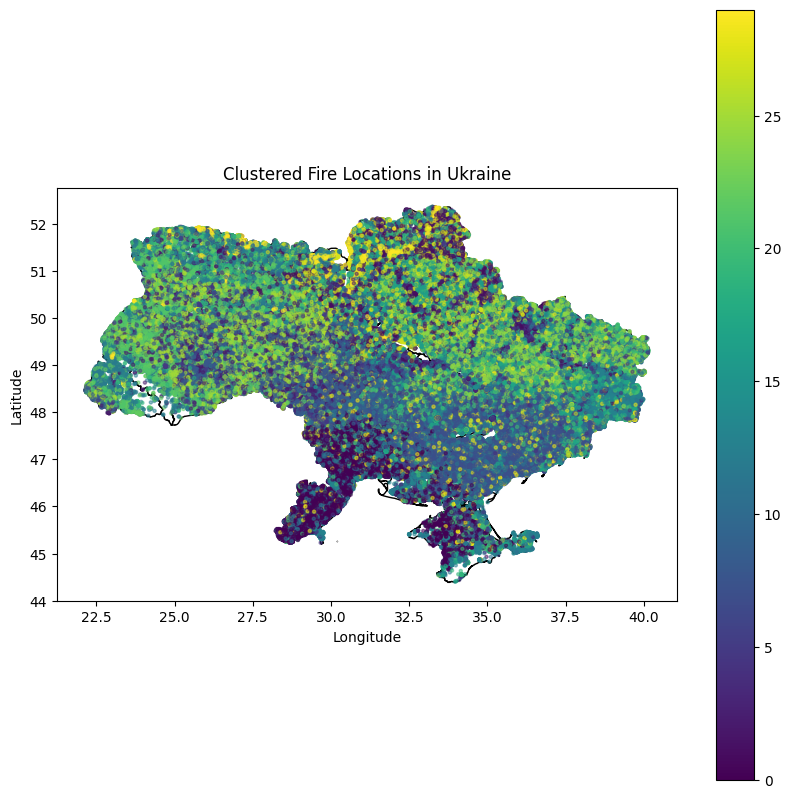

In [10]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
aggregated_data_sample_gdf = gpd.GeoDataFrame(X_ts_pre_sample, geometry=gpd.points_from_xy(X_ts_pre_sample.LONGITUDE, X_ts_pre_sample.LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
aggregated_data_sample_gdf.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Add cluster labels to the GeoDataFrame
aggregated_data_sample_gdf['cluster'] = y_labels

# Select only samples with certain cluster labels
# aggregated_data_sample_gdf = aggregated_data_sample_gdf[aggregated_data_sample_gdf['cluster'].isin([0])]

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
aggregated_data_sample_gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, alpha=0.5, legend=True)
plt.title('Clustered Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [11]:
# Lets train a model to predict the cluster labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# Split the data into training and testing sets
X_pre_train, X_pre_test, y_pre_train, y_pre_test = train_test_split(X_pre_pca_sample, y_labels, test_size=0.2)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_pre_train, y_pre_train)

# Predict the cluster labels
y_pre_proba = rf.predict_proba(X_pre_test)

# Get the predicted cluster labels from the probabilities
y_pre_pred = np.argmax(y_pre_proba, axis=1)

# Calculate the balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_pre_test, y_pre_pred)
balanced_accuracy

np.float64(0.9937319022659924)

In [12]:
# Apply the scaler and PCA to X_post data
X_post_scaled = scaler.transform(X_post)
X_post_scaled = pd.DataFrame(X_post_scaled, columns=X_post.columns)
X_post_pca = pca.transform(X_post_scaled)
X_post_pca = pd.DataFrame(X_post_pca)
# X_post_pca = pd.DataFrame(X_post_scaled)

X_post_pca.head()

,0,1,2,3,4,5,6,7,8
0,1.007677,3.160576,1.738921,1.650280,-2.439561,1.636757,-3.286248,-0.184321,0.800739
1,0.745974,1.484228,-0.656816,2.062342,-0.757827,1.209800,-2.231587,0.739370,0.327392
2,0.798824,2.701972,0.161065,2.758658,-1.184206,1.849851,-3.156556,-0.204798,1.057219
3,0.814997,2.682629,0.168014,2.765548,-1.184309,1.858453,-3.168950,-0.213887,1.030515
4,1.007677,3.160576,1.738921,1.650280,-2.439561,1.636757,-3.286248,-0.184321,0.800739


In [13]:
# Predict the cluster labels for the X_post data
y_post_proba = rf.predict_proba(X_post_pca)
y_post_pred = np.argmax(y_post_proba, axis=1)

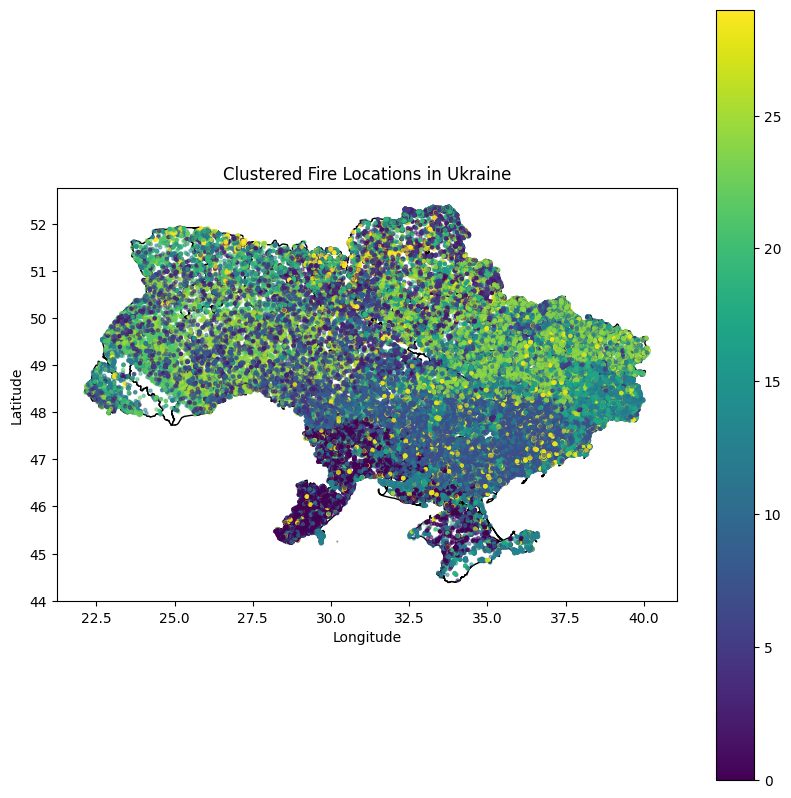

In [14]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
aggregated_data_sample_gdf = gpd.GeoDataFrame(X_ts_post, geometry=gpd.points_from_xy(X_ts_post.LONGITUDE, X_ts_post.LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
aggregated_data_sample_gdf.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Add cluster labels to the GeoDataFrame
aggregated_data_sample_gdf['cluster'] = y_post_pred

# Select only samples with certain cluster labels
# aggregated_data_sample_gdf = aggregated_data_sample_gdf[aggregated_data_sample_gdf['cluster'].isin([0])]

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
aggregated_data_sample_gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, alpha=0.5, legend=True)
plt.title('Clustered Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [15]:
# Average probability for the most probable cluster for post and pre war data
avg_prob_post = np.max(y_post_proba, axis=1).mean()
avg_prob_pre = np.max(y_pre_proba, axis=1).mean()
avg_prob_post, avg_prob_pre

(np.float64(0.906132825499231), np.float64(0.9750287))

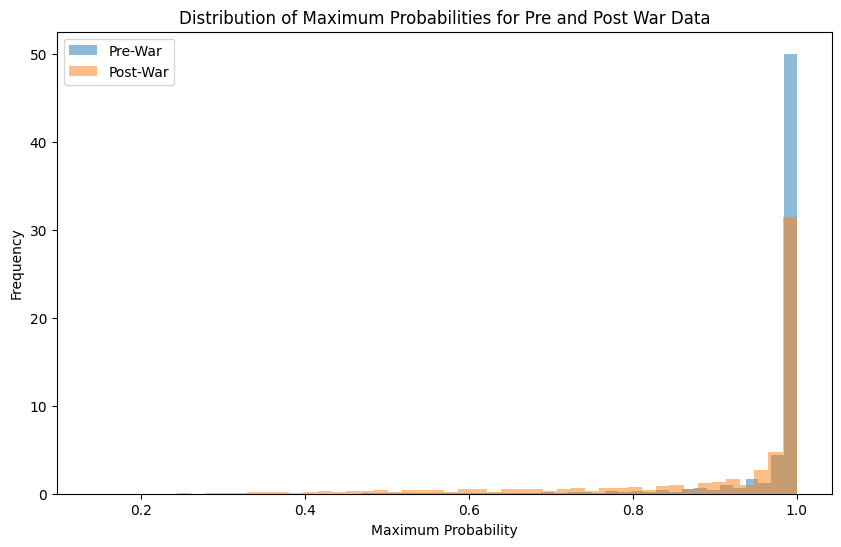

In [37]:
# Compare the distribution of probabilities for the pre and post war data
plt.figure(figsize=(10, 6))
plt.hist(y_pre_proba.max(axis=1), bins=50, alpha=0.5, label='Pre-War', density=True)
plt.hist(y_post_proba.max(axis=1), bins=50, alpha=0.5, label='Post-War', density=True)
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Maximum Probabilities for Pre and Post War Data')
plt.show()

In [56]:
from scipy.stats import entropy

# Calculate the entropy of the predicted probabilities for pre and post war data
entropy_pre = entropy(y_pre_proba, axis=1)
entropy_post = entropy(y_post_proba, axis=1)

# Set a threshold for out-of-distribution detection based on the pre-war data entropy
threshold_entropy = np.percentile(entropy_pre, 95)  # 95th percentile

# Detect out-of-distribution points in the post-war data
ood = pd.Series(entropy_post > threshold_entropy)

# Adjust the indices to fit with the original data
ood.index = X_post.index

# List the indices of out-of-distribution points
ood_indices = list(ood[ood].index)

# Print the results
print(f"Number of out-of-distribution points based on entropy: {ood.sum()}")
print(f"Indices of out-of-distribution points based on entropy: {ood_indices}")
print(f"Relative amount of out-of-distribution points based on entropy: {ood.mean()}")

Number of out-of-distribution points based on entropy: 93891
Indices of out-of-distribution points based on entropy: [896401, 896426, 896430, 896435, 896442, 896464, 896480, 896496, 896519, 896531, 896533, 896537, 896539, 896545, 896546, 896547, 896548, 896549, 896550, 896551, 896553, 896554, 896558, 896559, 896560, 896562, 896563, 896565, 896566, 896567, 896568, 896569, 896570, 896571, 896572, 896575, 896591, 896595, 896596, 896598, 896608, 896610, 896611, 896612, 896617, 896621, 896622, 896626, 896629, 896632, 896633, 896635, 896636, 896637, 896638, 896640, 896644, 896645, 896646, 896648, 896652, 896653, 896656, 896657, 896658, 896659, 896660, 896663, 896668, 896669, 896670, 896674, 896678, 896679, 896680, 896681, 896683, 896684, 896686, 896688, 896689, 896692, 896693, 896694, 896695, 896697, 896699, 896702, 896704, 896707, 896709, 896712, 896713, 896715, 896729, 896736, 896740, 896747, 896751, 896756, 896761, 896765, 896775, 896776, 896779, 896790, 896792, 896793, 896794, 896795, 89

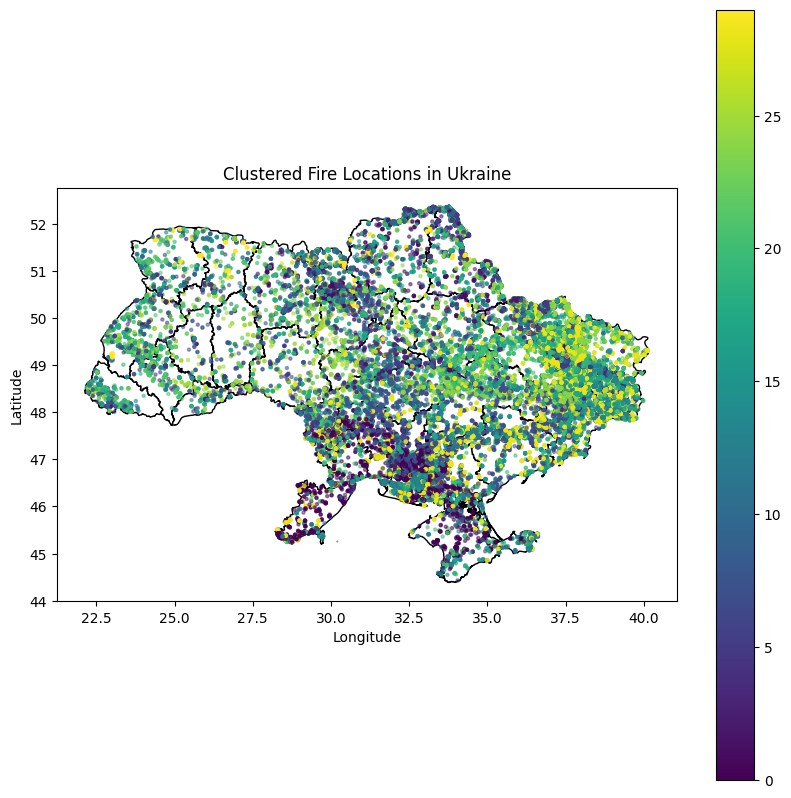

In [57]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
# Select only the out-of-distribution samples
aggregated_data_sample_gdf = gpd.GeoDataFrame(X_ts_post.loc[ood_indices], geometry=gpd.points_from_xy(X_ts_post.loc[ood_indices].LONGITUDE, X_ts_post.loc[ood_indices].LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
aggregated_data_sample_gdf.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Add cluster labels to the GeoDataFrame
y_post_pred_adj = pd.Series(y_post_pred)
y_post_pred_adj.index = X_post.index
aggregated_data_sample_gdf['cluster'] = y_post_pred_adj.loc[ood_indices]

# Select only samples with certain cluster labels
# aggregated_data_sample_gdf = aggregated_data_sample_gdf[aggregated_data_sample_gdf['cluster'].isin([0])]

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
aggregated_data_sample_gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, alpha=0.5, legend=True)
plt.title('Clustered Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()